
<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/books/structural_imaging/qsmxt_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>   </a>

## QSMxT Example

Author: Ashley Stewart

Original paper: https://onlinelibrary.wiley.com/doi/10.1002/mrm.29048

## Setup Neurodesk

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))


In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: AuthenticAMD
model name	: AMD EPYC-Rome Processor


# QSMxT Interactive Notebook

This interactive notebook estimates Quantitative Susceptibility Maps (QSMs) for two gradient-echo (GRE) MRI acquisitions using [QSMxT](https://github.com/QSMxT/QSMxT) provided by the [Neurodesk](https://neurodesk.org) project.

## What is QSM?

QSM is a form of quantitative MRI (qMRI) that estimates the magnetic susceptibility distribution across an imaged object. Magnetic susceptibility is the degree to which a material becomes magnetised by an external magnetic field. Major contributors to susceptibility include iron, calcium, and myelin, with the susceptibility of water typically approximating a zero-reference, though it is slightly diamagnetic. Read more about QSM [here](https://onlinelibrary.wiley.com/doi/10.1002/mrm.25358).

## What is QSMxT?

[QSMxT](https://qsmxt.github.io) is a suite of tools for building and running automated pipelines for QSM that:

- is available open-source without any licensing required;
- is distributed as a software container making it straightforward to access and install (Neurodesk!)
- scales its processing to execute across many acquisitions through jobs parallelisation (using multiple processors or HPCs) provided by [Nipype](https://nipype.readthedocs.io);
- automates steps that usually require manual intervention and scripting, including:
  - DICOM to [BIDS](https://bids-specification.readthedocs.io/en/stable/index.html) conversion;
  - QSM reconstruction using a range of algorithms;
  - segmentation using [FastSurfer](https://github.com/Deep-MI/FastSurfer);
  - group space generation using [ANTs](https://github.com/ANTsX/ANTs);
  - export of susceptibility statistics by subject and region of interest (ROI) to CSV.

![image.png](../images/image.png)

## How do I access QSMxT?

There are a few ways you can access QSMxT:

 - **This notebook**: You can access QSMxT in this notebook right now!
   - If you are running this on a Neurodesk Play instance, you can upload your own data into the sidebar via drag-and-drop.
 - **Neurodesktop**: QSMxT is in the applications menu of Neurodesktop.
   - On Neurodesk Play, upload your own data into the desktop via drag-and-drop.
   - On a local install of Neurodesk, bring any necessary files into the shared `~/neurodesktop-storage` directory
 - **Local install**: QSMxT can also be installed via the [Docker container](https://qsmxt.github.io/QSMxT/installation)
 - **HPC install**: QSMxT can also be installed via the [Singularity container](https://qsmxt.github.io/QSMxT/installation) for use on HPCs

# Download example DICOMs

Here, we download some example DICOMs from our OSF repository for QSMxT.

These data include GRE and T1-weighted acquisitions for one subject (duplicated to act as two subjects).

In [3]:
!pip install osfclient
!osf -p ru43c clone . > /dev/null 2>&1
!tar xf osfstorage/dicoms-unsorted.tar
!rm -rf osfstorage/
!tree dicoms-unsorted | head
!echo -e "...\nThere are `ls dicoms-unsorted | wc -l` unsorted DICOMs in ./dicoms-unsorted/"

dicoms-unsorted
├── MR.1.1.dcm
├── MR.1.10.dcm
├── MR.1.100.dcm
├── MR.1.101.dcm
├── MR.1.102.dcm
├── MR.1.103.dcm
├── MR.1.104.dcm
├── MR.1.105.dcm
├── MR.1.106.dcm
...
There are 1216 unsorted DICOMs in ./dicoms-unsorted/


# Load QSMxT

To load QSMxT inside a notebook, we can use the available module system:

In [4]:
import lmod
await lmod.load('qsmxt/7.2.0')
!qsmxt --version

[INFO]: QSMxT v7.2.0


# Data standardisation

QSMxT requires input data to conform to the [Brain Imaging Data Structure (BIDS)](https://bids.neuroimaging.io/).

Luckily, QSMxT also provides scripts that can convert unorganised NIfTI or DICOM images to BIDS. If you are using NIfTI images and do not have DICOMs, see [nifti-convert](https://qsmxt.github.io/QSMxT/using-qsmxt/data-preparation#nifti-to-bids).

## Sort DICOMs

Before we can convert DICOMs to BIDS cleanly, we need to sort the DICOMs by subject, session and series.

We can sort the DICOMs using `dicom-sort`.

Note that this script relies on accurate DICOM header information. If your data is sorted incorrectly, you may need to manually correct the sorting, or sort the files yourself. Be sure to follow the folder structure shown below.

In [5]:
!dicom-sort dicoms-unsorted dicoms-sorted

[INFO]: Running QSMxT 7.2.0
[INFO]: Command: /opt/miniconda-4.7.12.1/bin/dicom-sort dicoms-unsorted dicoms-sorted
[INFO]: Python interpreter: /opt/miniconda-4.7.12.1/bin/python3.8
[INFO]: Reading file list...
[INFO]: 1216 DICOM files found.
[INFO]: Sorting DICOMs in /home/jovyan/example-notebooks/books/structural_imaging/dicoms-sorted...
[INFO]: Identified subject: 1
[INFO]: Identified session: 1 #1 20170705
[INFO]: Identified series: sub-1/ses-20170705/series-6_mp2rage_highRes_0p5iso_slab
[INFO]: Identified session: 2 #1 20170705
[INFO]: Identified series: sub-2/ses-20170705/series-6_mp2rage_highRes_0p5iso_slab
[INFO]: Identified series: sub-1/ses-20170705/series-5_QSM_p2_1mmIso_TE20
[INFO]: Identified series: sub-2/ses-20170705/series-5_QSM_p2_1mmIso_TE20
[INFO]: Identified series: sub-1/ses-20170705/series-6_QSM_p2_1mmIso_TE20
[INFO]: Identified series: sub-2/ses-20170705/series-6_QSM_p2_1mmIso_TE20
[INFO]: Finished


Now we can see clearly that there are two subjects, each with one session, each with three DICOM series:

In [6]:
!tree dicoms-sorted -L 3

dicoms-sorted
├── log_2024-09-04_04-04-01832706.txt
├── references.txt
├── sub-1
│   └── ses-20170705
│       ├── series-5_QSM_p2_1mmIso_TE20
│       ├── series-6_QSM_p2_1mmIso_TE20
│       └── series-6_mp2rage_highRes_0p5iso_slab
└── sub-2
    └── ses-20170705
        ├── series-5_QSM_p2_1mmIso_TE20
        ├── series-6_QSM_p2_1mmIso_TE20
        └── series-6_mp2rage_highRes_0p5iso_slab

10 directories, 2 files


## Convert to BIDS

Now that the DICOMs are sorted, we can convert to BIDS using `dicom-convert`.

The DICOM to BIDS conversion must identify which series should be used for QSM reconstruction (T2*-weighted), and which series should be used for segmentation (T1-weighted). Because this information is not stored in the DICOM header, the user must provide it, or QSMxT can make a guess based on the `ProtocolName` field. By default, QSMxT assumes series matching any of the patterns in `['*qsm*', '*t2starw*']` are to be used for QSM, and series matching the pattern `['*t1w*']` are to be used for segmentation. If series cannot be identified, the user must do so. At minimum, at least one QSM series must be identified.

If QSMxT is run interactively, the user will be prompted to identify the relevant series'. However, because we are running QSMxT in a notebook, we disable the interactivity using `--auto_yes` and provide the missing information using command-line arguments (`--t1w_protocol_patterns` and `--qsm_protocol_patterns`). In this case, the T1-weighted scan requires identification, so we pass `--t1w_protocol_patterns "*mp2rage*"`:

In [7]:
!dicom-convert dicoms-sorted bids \
    --t1w_protocol_patterns "*mp2rage*" \
    --auto_yes

[INFO]: Running QSMxT 7.2.0
[INFO]: Command: /opt/miniconda-4.7.12.1/bin/dicom-convert dicoms-sorted bids --t1w_protocol_patterns *mp2rage* --auto_yes
[INFO]: Python interpreter: /opt/miniconda-4.7.12.1/bin/python3.8
[INFO]: Converting all DICOMs to NIfTI...
[INFO]: Running command: 'dcm2niix -z n -o "/home/jovyan/example-notebooks/books/structural_imaging/bids/sub-1/ses-20170705/extra_data" "/home/jovyan/example-notebooks/books/structural_imaging/dicoms-sorted/sub-1/ses-20170705/series-6_QSM_p2_1mmIso_TE20" >> "/home/jovyan/example-notebooks/books/structural_imaging/bids/sub-1/ses-20170705/extra_data/dcm2niix_output.txt"'
[INFO]: Running command: 'dcm2niix -z n -o "/home/jovyan/example-notebooks/books/structural_imaging/bids/sub-1/ses-20170705/extra_data" "/home/jovyan/example-notebooks/books/structural_imaging/dicoms-sorted/sub-1/ses-20170705/series-5_QSM_p2_1mmIso_TE20" >> "/home/jovyan/example-notebooks/books/structural_imaging/bids/sub-1/ses-20170705/extra_data/dcm2niix_output.txt

In [8]:
!tree bids

bids
├── README
├── dataset_description.json
├── log_2024-09-04_04-04-11572259.txt
├── references.txt
├── sub-1
│   └── ses-20170705
│       ├── anat
│       │   ├── sub-1_ses-20170705_acq-mp2ragehighres0p5isoslab_run-01_T1w.json
│       │   ├── sub-1_ses-20170705_acq-mp2ragehighres0p5isoslab_run-01_T1w.nii
│       │   ├── sub-1_ses-20170705_acq-qsmp21mmisote20_run-01_part-mag_T2starw.json
│       │   ├── sub-1_ses-20170705_acq-qsmp21mmisote20_run-01_part-mag_T2starw.nii
│       │   ├── sub-1_ses-20170705_acq-qsmp21mmisote20_run-01_part-phase_T2starw.json
│       │   └── sub-1_ses-20170705_acq-qsmp21mmisote20_run-01_part-phase_T2starw.nii
│       └── extra_data
│           └── dcm2niix_output.txt
└── sub-2
    └── ses-20170705
        ├── anat
        │   ├── sub-2_ses-20170705_acq-mp2ragehighres0p5isoslab_run-01_T1w.json
        │   ├── sub-2_ses-20170705_acq-mp2ragehighres0p5isoslab_run-01_T1w.nii
        │   ├── sub-2_ses-20170705_acq-qsmp21mmisote20_run-01_part-mag_T2starw.json
   

# Inspect input data

Here we define a function we will use to visualise NIfTI images so we can view some of the input data:

In [9]:
from glob import glob
def show_nii(nii_path, title=None, cmap='gray', **imshow_args):
    from matplotlib import pyplot as plt
    import numpy as np
    import nibabel as nib
    import glob

    # load data\n",
    data_1 = nib.load(nii_path).get_fdata()

    # get middle slices\n",
    slc_data1 = np.rot90(data_1[np.shape(data_1)[0]//2,:,:])
    slc_data2 = np.rot90(data_1[:,np.shape(data_1)[1]//2,:])
    slc_data3 = np.rot90(data_1[:,:,np.shape(data_1)[2]//2])

    # show slices\n",
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,10))
    if title: plt.suptitle(title)

    axes[0].imshow(slc_data1, cmap=cmap, **imshow_args)
    axes[1].imshow(slc_data2, cmap=cmap, **imshow_args)
    axes[2].imshow(slc_data3, cmap=cmap, **imshow_args)

    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')

    fig.tight_layout()
    fig.subplots_adjust(top=1.55)
    plt.show()

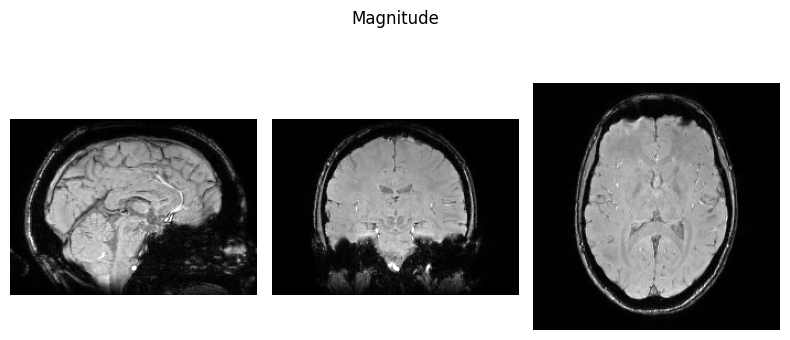

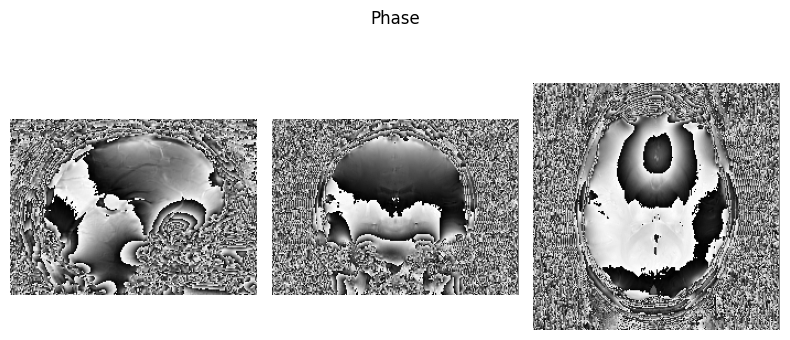

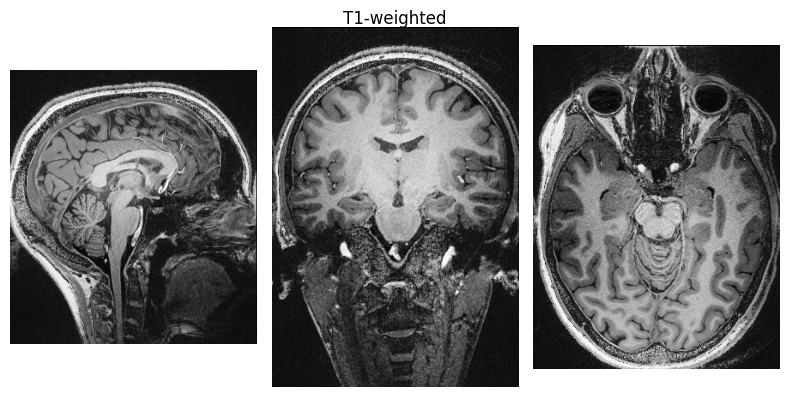

In [10]:
show_nii(glob("bids/sub-*/ses-*/anat/*mag*nii*")[0], title="Magnitude", vmax=500)
show_nii(glob("bids/sub-*/ses-*/anat/*phase*nii*")[0], title="Phase")
show_nii(glob("bids/sub-*/ses-*/anat/*T1w*nii*")[0], title="T1-weighted")

# Run QSMxT

We are now ready to run QSMxT! We will generate susceptibility maps and segmentations, and export analysis CSVs to file.

The usual way of running QSMxT is to use `qsmxt bids_dir`. This will launch an interactive command-line interface (CLI) to setup your desired pipelines. However, since we are running this in a notebook, we need to use command-line arguments to by-pass the interface and execute a pipeline.

But first, let's consider our pipeline settings. For QSM reconstruction, QSMxT provides a range of sensible defaults fit for different purposes. We can list the premade QSM pipelines using `--list_premades`. For the full pipeline details used for each premade pipeline, see [qsm_pipelines.json](https://github.com/QSMxT/QSMxT/blob/master/qsm_pipelines.json).

In [11]:
!qsmxt --list_premades

=== Premade pipelines ===
default: Default QSMxT settings (GRE; assumes human brain)
gre: Applies suggested settings for 3D-GRE images
epi: Applies suggested settings for 3D-EPI images (assumes human brain)
bet: Applies a traditional BET-masking approach (artefact reduction unavailable; assumes human brain)
fast: Applies a set of fast algorithms
body: Applies suggested settings for non-brain applications
nextqsm: Applies suggested settings for running the NeXtQSM algorithm (assumes human brain)
[INFO]: Finished


For this demonstration, we will go with the `fast` pipeline. To export segmentations and analysis results, we will use `--do_segmentation` and `--do_analysis`. The `--auto_yes` option avoid the interactive CLI interface that cannot be used in a notebook:

In [12]:
!qsmxt bids \
    --premade fast \
    --do_qsm \
    --do_segmentation \
    --do_analysis \
    --auto_yes

[INFO]: QSMxT v7.2.0
[INFO]: Python interpreter: /opt/miniconda-4.7.12.1/bin/python3.8
[INFO]: Command: qsmxt /home/jovyan/example-notebooks/books/structural_imaging/bids --premade 'fast' --do_qsm --do_segmentation --do_analysis --auto_yes
[WARNING]: Pipeline is NOT guidelines compliant (see https://doi.org/10.1002/mrm.30006):; Phase-quality-based masking recommended
[INFO]: Available memory: 98.042 GB
[INFO]: Creating QSMxT workflow for sub-1.ses-20170705.acq-qsmp21mmisote20.run-01...
[INFO]: Creating QSMxT workflow for sub-2.ses-20170705.acq-qsmp21mmisote20.run-01...
[INFO]: Running using MultiProc plugin with n_procs=32
240904-04:04:40,658 nipype.workflow INFO:
	 Workflow qsmxt-workflow settings: ['check', 'execution', 'logging', 'monitoring']
240904-04:04:40,714 nipype.workflow INFO:
	 Running in parallel.
240904-04:04:40,721 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 12 jobs ready. Free memory (GB): 113.21/113.21, Free processors: 32/32.
240904-04:04:41,341 nipype.wo

# View results

Let's have a look at the generated `qsm` folder:

In [16]:
!tree bids/derivatives/qsmxt-*-* --dirsfirst

bids/derivatives/qsmxt-2024-09-04-035503
bids/derivatives/qsmxt-2024-09-04-040438
├── sub-1
│   └── ses-20170705
│       ├── anat
│       │   ├── sub-1_ses-20170705_run-01_acq-qsmp21mmisote20_Chimap.nii
│       │   ├── sub-1_ses-20170705_run-01_acq-qsmp21mmisote20_space-orig_dseg.nii
│       │   └── sub-1_ses-20170705_run-01_acq-qsmp21mmisote20_space-qsm_dseg.nii
│       └── extra_data
│           ├── sub-1_ses-20170705_run-01_acq-qsmp21mmisote20_desc-t1w-to-qsm_transform.mat
│           └── sub-1_ses-20170705_run-01_acq-qsmp21mmisote20_qsm-analysis.csv
├── sub-2
│   └── ses-20170705
│       ├── anat
│       │   ├── sub-2_ses-20170705_run-01_acq-qsmp21mmisote20_Chimap.nii
│       │   ├── sub-2_ses-20170705_run-01_acq-qsmp21mmisote20_space-orig_dseg.nii
│       │   └── sub-2_ses-20170705_run-01_acq-qsmp21mmisote20_space-qsm_dseg.nii
│       └── extra_data
│           ├── sub-2_ses-20170705_run-01_acq-qsmp21mmisote20_desc-t1w-to-qsm_transform.mat
│           └── sub-2_ses-20170705_run-01

The `references.txt` file contains a list of all the algorithms used and relevant citations:

In [17]:
!cat bids/derivatives/qsmxt-*-*/references.txt

== References ==

 - QSMxT: Stewart AW, Robinson SD, O'Brien K, et al. QSMxT: Robust masking and artifact reduction for quantitative susceptibility mapping. Magnetic Resonance in Medicine. 2022;87(3):1289-1300. doi:10.1002/mrm.29048

 - QSMxT: Stewart AW, Bollman S, et al. QSMxT/QSMxT. GitHub; 2022. https://github.com/QSMxT/QSMxT

 - Python package - Nipype: Gorgolewski K, Burns C, Madison C, et al. Nipype: A Flexible, Lightweight and Extensible Neuroimaging Data Processing Framework in Python. Frontiers in Neuroinformatics. 2011;5. Accessed April 20, 2022. doi:10.3389/fninf.2011.00013

 - Brain extraction: Smith SM. Fast robust automated brain extraction. Human Brain Mapping. 2002;17(3):143-155. doi:10.1002/hbm.10062

 - Brain extraction: Liangfu Chen. liangfu/bet2 - Standalone Brain Extraction Tool. GitHub; 2015. https://github.com/liangfu/bet2

 - Unwrapping algorithm - ROMEO: Dymerska B, Eckstein K, Bachrata B, et al. Phase unwrapping with a rapid opensource minimum spanning tree a

Let's view one of the QSM results:

## QSM results

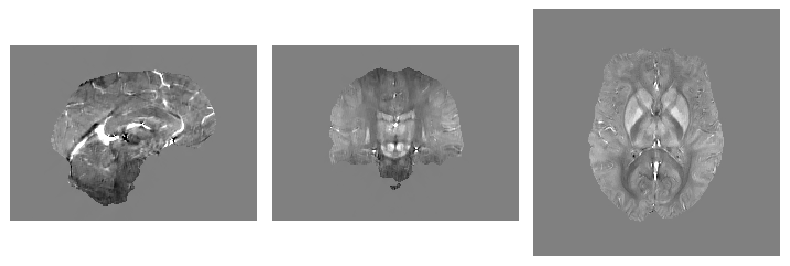

In [18]:
show_nii(glob("bids/derivatives/qsmxt-*-*/sub*/ses*/anat*/*Chimap.nii*")[0], cmap='gray', vmin=-0.15, vmax=+0.15, interpolation='nearest')

## Segmentations

Segmentations are generated in both the QSM space and the T1-weighted space. Transformations are also made available.

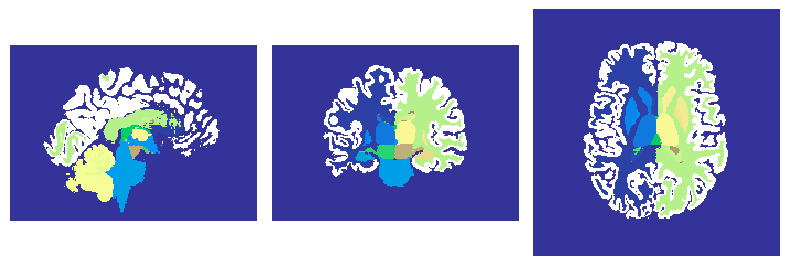

In [19]:
show_nii(glob("bids/derivatives/qsmxt-2*/sub*/ses*/anat*/*dseg.nii*")[0], cmap='terrain', vmin=0, vmax=96, interpolation='nearest')

## Analysis CSVs

CSV files have been exported containing susceptibility values in regions of interest for each subject.

Here we will load the CSVs, inspect the data and generate figures:

In [20]:
!pip install seaborn numpy nibabel pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 16.1 MB/s eta 0:00:00


In [21]:
# import modules
import numpy as np
import nibabel as nib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob

The raw CSV files use names from FreeSurfer as exported by FastSurfer. The full list of regions is available [here](https://github.com/QSMxT/QSMxT/blob/master/aseg_labels.csv).

In [23]:
pd.read_csv(glob("bids/derivatives/qsmxt-*-*/sub*/ses*/extra*/*.csv")[0])

,roi,num_voxels,min,max,median,mean,std
0,3rd-Ventricle,589,-0.234913,0.125160,-0.019229,-0.022606,0.034589
1,4th-Ventricle,1567,-0.126959,0.032041,-0.047888,-0.048661,0.029106
2,Brain-Stem,18982,-0.279218,0.103292,-0.044871,-0.040889,0.028910
3,CSF,846,-1.393660,0.945973,0.024908,0.027376,0.141301
4,Left-Accumbens-area,511,-0.142032,0.128779,0.021214,0.020016,0.030764
...,...,...,...,...,...,...,...
91,ctx-rh-superiorfrontal,29774,-0.133657,0.252094,-0.003924,-0.009370,0.024408
92,ctx-rh-superiorparietal,12097,-0.084345,0.306848,-0.015679,-0.014934,0.021954
93,ctx-rh-superiortemporal,16451,-0.090617,0.248823,0.005915,0.012763,0.024190
94,ctx-rh-supramarginal,12121,-0.082152,0.240121,0.018353,0.019162,0.023193


We will select a subset of these ROIs and give them more readable names:

In [24]:
# define regions of interest
# see https://github.com/QSMxT/QSMxT/blob/master/aseg_labels.csv for a full list
rois = { 
    "Thalamus" : [9, 10, 48, 49],
    "Pallidum" : [12, 13, 52, 53],
    "Caudate" : [11, 50],
    "Putamen" : [12, 51],
    "Brain stem" : [16],
    "CSF" : [24, 122, 257, 701],
    "White matter" : [2, 7, 41, 46, 177]
}
roi_names = { value: key for key in rois for value in rois[key] }
roi_ids = [value for roi in rois.values() for value in roi]

In [25]:
# load a reconstruction
qsm = nib.load(glob("bids/derivatives/qsmxt-*-*/sub*/ses*/anat*/*Chimap.nii*")[0]).get_fdata().flatten()
seg = nib.load(glob("bids/derivatives/qsmxt-*-*/sub*/ses*/anat*/*dseg.nii*")[0]).get_fdata().flatten()

In [26]:
# retain only the rois
qsm = qsm[np.isin(seg, roi_ids)]
seg = seg[np.isin(seg, roi_ids)]

In [27]:
# convert to a dataframe for plotting purposes
seg = pd.Series(seg).map(roi_names)
data = pd.DataFrame({ 'qsm' : qsm, 'seg' : seg })

In [28]:
# summarise data by region including the average and standard deviation
data.groupby('seg')['qsm'].agg(['mean', 'std']).sort_values('mean').round(decimals=3)

,mean,std
seg,,
Brain stem,-0.041,0.029
White matter,-0.002,0.027
CSF,0.027,0.141
Thalamus,0.030,0.034
Pallidum,0.033,0.060
Putamen,0.047,0.034
Caudate,0.048,0.024


In [29]:
medians = data.groupby('seg')['qsm'].median().sort_values()
order = medians.index

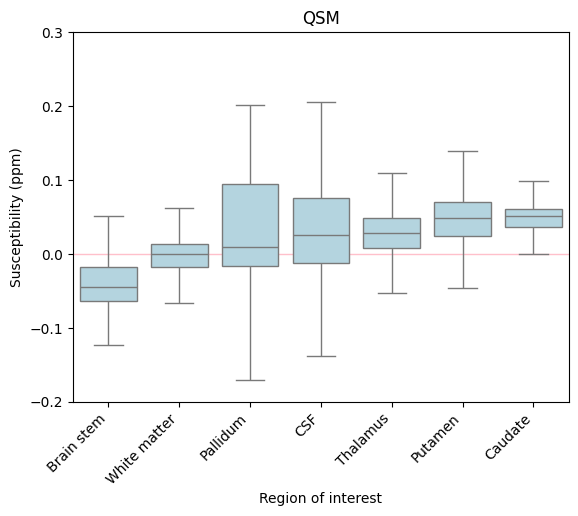

In [31]:
# plot
fig, ax = plt.subplots()
sns.boxplot(data=data, y='qsm', x='seg', fliersize=0, color='lightblue', order=order, ax=ax)
ax.set_xticks(range(len(ax.get_xticks())))  # Set tick positions explicitly
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
ax.set_ylim(-0.2, 0.3)
ax.axhline(y=0, color='pink', linestyle='-', linewidth=1, zorder=-1)
ax.set_xlabel("Region of interest")
ax.set_ylabel("Susceptibility (ppm)")
ax.set_title("QSM")
plt.show()